# Dirichlet Processes

Note: A significant portion of this lecture is modified from [this documentation](https://pymc-devs.github.io/pymc3/notebooks/dp_mix.html), written by Austin Rochford.

### Let's go to the board first for a motivating cluster example. I'll add these changes in a bit.


We have seen with parametric mixture models that we can assign group labels to observations using a model, but so far we have assumed that we know how many groups there are *a priori*. What if we don't know how many groups produced the data? We often want the choice of $K$ to be **data-driven**.

There are a number of approaches for allocating samples to groups where the number of groups is not pre-determined. We will look at two generative methods here.


## The Bayesian Histogram

One way to approximate an unknown density using sample observations is using a *histogram*. One way to parametrically describe a histogram is by specifying a series of knots that define the bins of a histogram:

$$\zeta = \{\zeta_i: \zeta_1 \lt \zeta_2 \lt \ldots \lt \zeta_k \}_{h=1}^k$$

We can specify an associated probability model as:

$$f(x) = \sum_{h=i}^k I(\zeta_{h-1} \lt x \le \zeta_h) \frac{\pi_h}{\zeta_h - \zeta_{h-1}}$$

where $I$ is the indicator function and $\pi = \pi_1, \ldots, \pi_k$ a probability simplex.

We require a prior for the unknown probabilities, for which a natural choice is the *Dirichlet* distribution:

$$f(\mathbf{\pi}) = \frac{\prod \Gamma(\alpha_h)}{\Gamma(\sum_{h=1}^k \alpha_h)}\prod_{h=1}^{k} \pi_h^{\alpha_h - 1}$$

$$\text{where } \, E(\pi|\alpha) = \pi_0 = \frac{\alpha_1}{\sum_h \alpha_h}, \ldots , \frac{\alpha_k}{\sum_h \alpha_h}$$

Notice that the Dirichlet is just a generalization of the beta distribution to $k \gt 2$ classes.

It is easy to show that the resulting posterior distribution for $\pi$ is another Dirichlet:

$$\pi|x \sim \text{Dirichlet}(\alpha_1 + n_i, \ldots, \alpha_k + n_k)$$

where $n_h$ is the number of observations contained by the $h^{th}$ histogram bin.

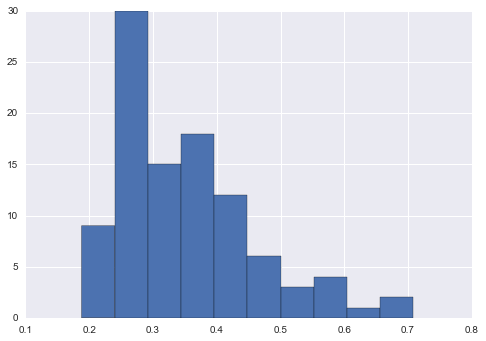

In [33]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as T
import seaborn as sns; sns.set_context('notebook')
import pymc3
import matplotlib.pyplot as plt
np.random.seed(13525677)

n = 100
y = 0.75 * np.random.beta(1, 5, n) + 0.25 * np.random.beta(20, 2, n)

counts, bins, patches = plt.hist(y, bins=10)

In [2]:
counts

array([  9.,  30.,  15.,  18.,  12.,   6.,   3.,   4.,   1.,   2.])

We can use these bin counts to calculate the expected value of the Dirichlet posterior:

In [3]:
import numpy as np

p = np.random.dirichlet(1+counts)
p = np.append(p, 1.-p.sum())
y_exp = n*p

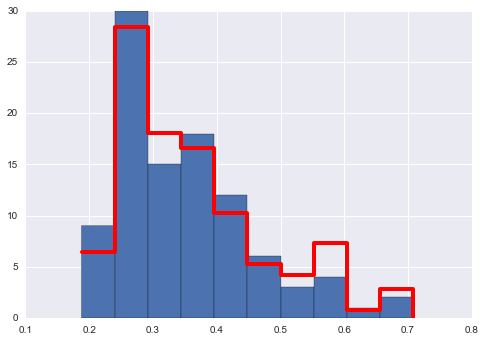

In [4]:
plt.hist(y, bins=10)
plt.step(bins, y_exp, color='red', where='post', linewidth=4)

While this does a good job of density approximation, the estimates are clearly sensitive to the choice of bins (both number and location):

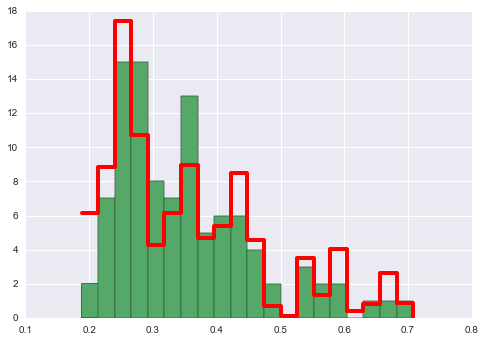

In [5]:
counts, bins, patches = plt.hist(y, bins=20)

p = np.random.dirichlet(1+counts) 
y_exp = n*np.append(p, 1.-p.sum())

plt.hist(y, bins=20)
plt.step(bins, y_exp, color='red', where='post', linewidth=4)

So, while this is a simple, straightforward approach to flexible density estimation, we would prefer not to have to specify bins *a priori*. Happily, with a little work, we can generalize the Dirichlet to make it more flexible

## Dirichlet Process Prior

Consider a sample space $\Omega$ that we may partition into $k$ non-overlapping subsets $\{B_1,\ldots,B_k\} \in \mathcal{B}$. We can assign a probability measure $P$ to this partition:

$$P(B_1),\ldots,P(B_k) = \int_{B_1} f(x) dx, \ldots, \int_{B_k} f(x) dx$$

A Dirichlet distribition would be a natural conjugate prior on these partition (bin) probabilities:

$$P(B_1),\ldots,P(B_k) \sim \text{Dirichlet}(a P_0(B_1), \ldots, a P_0(B_k))$$

where $P_0$ is a base probability measure and $a > 0$ can be interpreted as prior sample size, which essentially controls the amount of prior shrinkage.

However, we want our model to be insensitive to the choice of partition and to the number of bins. The important implication of specifying this prior is that although probabilities are assigned to each bin, it does not prescribe how that probability mass is distributed across any particular bin.

If we combine (or split) the elements of a Dirichlet distribution, it results in another Dirichlet:

$$\begin{aligned}
\pi_1, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1, \ldots, \alpha_k) \\
\Rightarrow \pi_1 + \pi_2, \pi_3, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1 + \alpha_2, \alpha_3, \ldots, \alpha_k)
\end{aligned}$$

or generally, for partition $\{B_1,\ldots,B_k\} \in \mathcal{B}$:

$$\sum_{h \in B_1} \pi_h, \ldots, \sum_{h \in B_k} \pi_h \sim \text{Dirichlet}(\sum_{h \in B_1} \alpha_h, \ldots, \sum_{h \in B_k} \alpha_h)$$

Similarly, for $\beta_1 + \beta_2 = 1$,

$$\begin{aligned}
\pi_1, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1, \ldots, \alpha_k) \\
\tau_1, \tau_2 &\sim \text{Dirichlet}(\alpha_1 \beta_1, \alpha_1 \beta_2) \\
\Rightarrow \pi_1\tau_1 + \pi_1\tau_2, \pi_2, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1\beta_1, \alpha_1\beta_2, \alpha_2, \alpha_3, \ldots, \alpha_k)
\end{aligned}$$

Just as the Gaussian process is a distribution over functions, a **Dirichlet process** is a distribution over distributions (or, measure over measures). 

$$P \sim DP(\alpha, P_0)$$

It is centered upon the baseline probability measure $P_0$, with $\alpha$ specifying the certainty in this baseline (*i.e.* inverse variance).

The expectation of a DPP is:

$$E[P(B)] = P_0(B)$$

in other words, centered on the baseline measure, and the variance is:

$$\text{Var}(P(B)) = \frac{P_0(B)(1-P_0(B))}{1 + \alpha}$$

It is essentially an *infinitely decimated* Dirichlet distribution. The marginal probability assigned to any subset $B$ is beta distributed:

$$P(B) \sim \text{Beta}(\alpha P_0(B), \alpha (1-P_0(B)))$$

- If $P$ is a distributed as $DP(\alpha, P_0$), then $P$ is a random probability measure that has the same support as $P_0$

### Cool, but how does one produce draws from this distribution?


Several ways to do this, but the most popular, and interesting method is the stick breaking process.

## Stick-breaking Process

The specification of the DP above may not be intuitive, in terms of what a DP realization looks like. A generative approach for allocating observations to groups is the stick-breaking process, which involves breaking the support of a particular variable into $k$ disjoint segments. Here, we start with a "stick" of unit length. To "break" the stick, we generate random points along the stick via the following algorithm:

1. generate a random variable $\beta_1 \sim Beta(1, \alpha)$
2. use this random variable (which is on the unit interval) to define a break point on the stick
3. iterate $k-1$ times:
    - generate $\beta_i \sim Beta(1, \alpha)$
    - identify next break point at $\pi_i = \beta_i \prod_{j=1}^{i-1} (1-\beta_j)$ (which is on the part of the stick that remains after the previous break)
    -

This results in the creation of $k$ "pieces". Associated with each piece is a probability that is proportional to its length; these $k$ probabilities will have a Dirichlet distribution -- thus, the DP is a distribution over distributions. 

This process defines an **exchangeable** distribution on partitions of the stick; though there is an order to the generation of the segments, the distribution is independent of order.

Notice that $k$ can be infinite, making $G$ an infinite mixture.

One way to implement a stick-breaking constructive process in Python is as follows:

In [6]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset
from theano import tensor as T
%matplotlib inline

In [7]:
from numpy.random import beta

def stick_breaking(alpha, k):
    betas = beta(1, alpha, k)
    remaining_pieces = np.append(1, np.cumprod(1 - betas[:-1]))
    p = betas * remaining_pieces
    return p/p.sum()

For example, let's construct a DP with a baseline distribution that is standard normal:
$$ P_0 \sim N(0,1)$$

We take a draw of $k$ values from the baseline distribution,
$\theta_1, \theta_2,\ldots, \theta_k\sim P_0$

In [8]:
k = 25
alpha = 1.7
theta = np.random.normal(0, 1, k)

then, using a stick breaking process, we can obtain a set of draws $\beta_1, \beta_2, \ldots$ from a $\text{Beta}(1,\alpha)$. These are used to assign probabilities to the $\theta_i$ values. As we established above, the probability of each $\theta_i$ is calculated via:

$$ \pi_i = \beta_i \prod_{j=1}^{i-1} (1 - \beta_j) $$

In [9]:
p = stick_breaking(alpha, k)
p

array([  2.83378888e-01,   2.87102563e-01,   1.71899450e-01,
         3.03801928e-02,   9.69333277e-02,   7.50054196e-02,
         5.24364245e-02,   1.05530999e-03,   1.18150012e-03,
         4.03520258e-04,   5.00556493e-05,   4.25757458e-05,
         2.07148570e-05,   3.17429600e-05,   9.63723573e-06,
         2.15394732e-05,   6.46122232e-06,   2.44097639e-05,
         1.77079861e-06,   1.08720738e-05,   1.48219402e-06,
         9.81445659e-07,   1.00745755e-06,   1.51763988e-07,
         1.32267293e-09])

So the Dirichlet Process density $P$ is given by
$$ p(x) = \sum_{i=1}^\infty\pi_i I(x = \theta_i)$$
where $I$ is the indicator function.

In [10]:
x = np.random.multinomial(k, p)
dp = theta[x]
dp

array([ 0.2182698 , -0.38916088, -0.38916088,  0.35746671,  0.70760178,
        0.35746671,  0.95103041,  0.95103041,  0.95103041,  0.95103041,
        0.95103041,  0.95103041,  0.95103041,  0.95103041,  0.95103041,
        0.95103041,  0.95103041,  0.95103041,  0.95103041,  0.95103041,
        0.95103041,  0.95103041,  0.95103041,  0.95103041,  0.95103041])

<Container object of 5 artists>

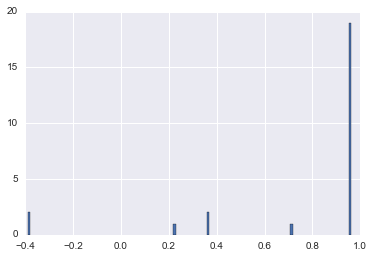

In [11]:
x = set(dp)
f = [(dp==i).sum() for i in x]
plt.bar(x, f, width=0.01)

In [12]:
from numpy.random import choice

def dirichlet_process(p, n, P0=np.random.randn):
    theta = P0(len(p))
    return(np.random.choice(theta, size=n, p=p))

In [13]:
p = stick_breaking(alpha=1, k=1000)

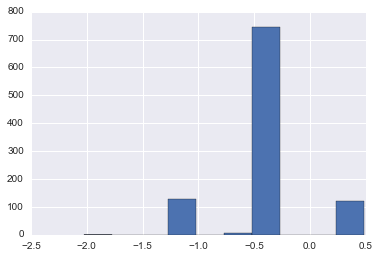

In [14]:
_ = plt.hist(dirichlet_process(p, 1000))

We can see this alternatively through the CDF

In [15]:
N = 20 ## Draws from Dirichlet process
K = 30
alpha = 2.
P0 = sp.stats.norm

In [16]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

x_plot = np.linspace(-3, 3, 200)

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

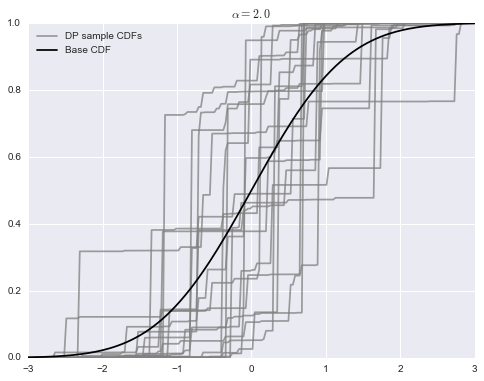

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
        label='DP sample CDFs');
ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'$\alpha = {}$'.format(alpha));
ax.legend(loc=2);

- Let's see how changing the alpha changes the cdf

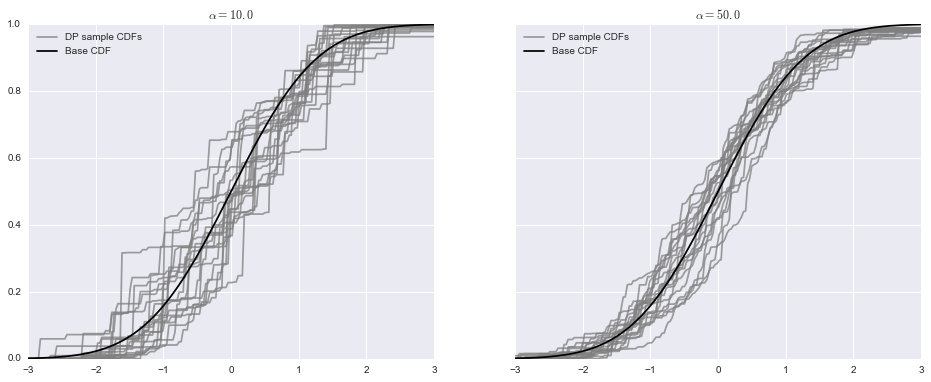

In [18]:
fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

K = 50
alpha = 10.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

l_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

l_ax.set_title(r'$\alpha = {}$'.format(alpha));
l_ax.legend(loc=2);

K = 200
alpha = 50.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

r_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

r_ax.set_title(r'$\alpha = {}$'.format(alpha));
r_ax.legend(loc=2);

Notice that, while the particular values of the DP realizations are continuous, the distribution is discrete. But, as $\alpha \rightarrow \infty$, the likelihood of indexing the same $\theta_h$ more than once goes to zero, and one is essentially drawing from $P_0$.

So, while the DP is of limited use as a direct prior of a data distribution, it is extremely useful as a prior for an unknown mixture.
If we generalize the above approach such that the DP is used as the mixture measure for some kernel $\mathcal{K}(y|\theta)$, then we can define the mixture model:
$$f(y) = \sum_{h=1}^{\infty} \pi_h \mathcal{K}(y|\theta_h)$$
This is no different than other mixture models we have seen, except that the number of components is infinite. In practice, almost all the components are empty when we consider using it to model a finite dataset, but the model has the capacity to increase the number of mixture components as data are added.
This model can be specified hierarchically by:
$$\begin{aligned}
P \sim DP(\alpha,P_0) \\
\theta_i \sim P \\
y_i\sim \mathcal{K}(y|\theta_i)
\end{aligned}$$

### Dirichlet Process Mixture model

Suppose we wish to perform density estimation. We can perform this by defining the following hierarchical structure:
$$\begin{aligned}
x_i|\phi_i\sim f_{\theta_i} \\
\phi_1,\ldots,\phi_n \sim P\\
P\sim DP(\alpha, P_0)
\end{aligned}$$





### Density Estimation revisited

Let's see what the generation process for a DP mixture looks like...

In [19]:
N = 10# just for example, we'll generate a number of different possible mixtures
K = 30
alpha = 1.3
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

In [20]:
## Stick Breaking process
beta = sp.stats.beta.rvs(1, alpha, size=(N,K))
w = np.empty_like(beta)
w[:,0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(K))

dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

Let's check out the generated mixtures.

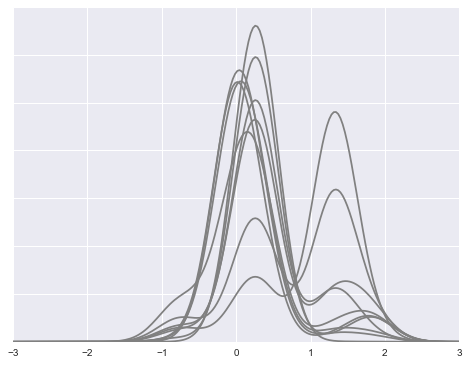

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c='gray');

ax.set_yticklabels([]);

We're going to just focus on one and see how it's is a sum of individual densities

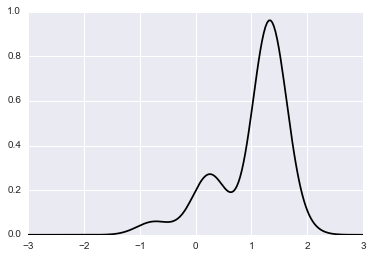

In [25]:
ix = 6
plt.plot(x_plot, dpm_pdfs[ix], c='k', label='Density');

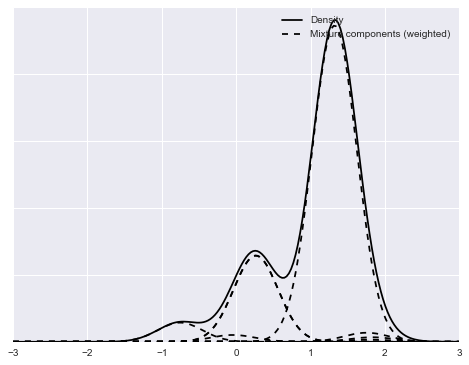

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 6

ax.plot(x_plot, dpm_pdfs[ix], c='k', label='Density');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
        '--', c='k', label='Mixture components (weighted)');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T,
        '--', c='k');

ax.set_yticklabels([]);
ax.legend(loc=1);

In [28]:
# what are the weights associated with the mixture? 
w[0]

array([  3.17532733e-01,   6.38455046e-01,   2.22068632e-02,
         1.35587886e-02,   6.79388394e-04,   1.30440006e-03,
         1.86705115e-03,   2.01696399e-03,   1.39595326e-03,
         8.06982567e-05,   6.93975235e-04,   5.86421167e-05,
         9.20686426e-05,   1.73149483e-05,   8.07797561e-07,
         3.61233189e-08,   2.48186943e-05,   2.28356732e-06,
         5.53244654e-06,   3.95394722e-06,   1.88427767e-06,
         6.18352293e-08,   6.80682644e-07,   3.64299884e-08,
         1.32480917e-09,   1.20186321e-09,   8.94308673e-09,
         1.96031552e-09,   6.00651055e-10,   2.97924136e-09])

One of the difficulties in implementing DP computationally is how to handle an infinite mixture. The easiest way to tackle this is by using a truncated Dirichlet process to approximate the full process. This can be done by choosing a size $N$ that is sufficiently large that it will exceed the number of point masses required. By doing this, we are assuming

$$ \sum_{i=1}^{\infty} p_i I(x=\theta_i) \approx \sum_{i=1}^{N} p_i I(x=\theta_i) $$

[Ohlssen et al. 2007](http://onlinelibrary.wiley.com/doi/10.1002/sim.2666/abstract) provide a rule of thumb for choosing $N$ such that the sum of the first $k-1$ point masses is greater than 0.99:

$$ N \approx 5\alpha + 2 $$

To be conservative, we will choose an even larger value (100), which we will call `N_dp`.

### Example: Old Faithful Geyer Waiting times

In [34]:
from statsmodels.datasets import get_rdataset
## Geyser example 
old_faithful_df = get_rdataset('faithful', cache=True).data[['waiting']]
old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()
old_faithful_df.head()

,waiting,std_waiting
0,79,0.596025
1,54,-1.242890
2,74,0.228242
3,62,-0.654437
4,85,1.037364


Let's plot the data and see what we get!

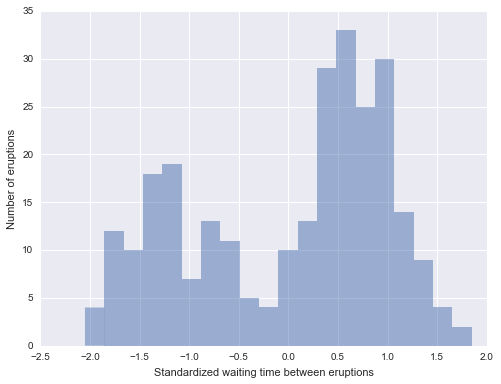

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(-3, 3, 200)
n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, lw=0, alpha=0.5);

ax.set_xlabel('Standardized waiting time between eruptions');
ax.set_ylabel('Number of eruptions');

Model for these data:
$$
\begin{align}
   x_i|\mu_i \sim\mathcal{N}(\mu_i, \tau_i^-1)\\
   \mu_i|\tau_i \sim\mathcal{N}(0, \tau_i^-1)\\
   \tau_i \sim DP(\alpha, \Gamma(1,1)\\
   \alpha\sim \Gamma(1,1)
\end{align}
$$

In [37]:
N = old_faithful_df.shape[0]
K = 30

We can implement this in `pymc3` in the following way:

In [38]:
#### Define the model 

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]])) #stick break
    component = pm.Categorical('component', w, shape=N)

    tau = pm.Gamma('tau', 1., 1., shape=K)
    mu = pm.Normal('mu', 0, tau = tau, shape=K)
    obs = pm.Normal('obs', mu[component], tau = tau[component],
                    observed=old_faithful_df.std_waiting.values)

Applied log-transform to alpha and added transformed alpha_log to model.
Applied logodds-transform to beta and added transformed beta_logodds to model.
Applied log-transform to tau and added transformed tau_log to model.


In [39]:
with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, tau, mu, obs])
    trace_ = pm.sample(2000, [step1])

trace = trace_[1000::10]

Assigned ElemwiseCategorical to component
 [-----------------100%-----------------] 2000 of 2000 complete in 25.1 sec

- Check out the trace and posterior density of alpha

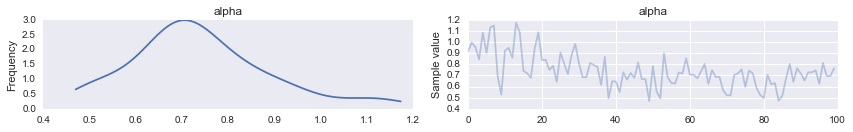

In [40]:
pm.traceplot(trace, varnames=['alpha']);

In [41]:
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

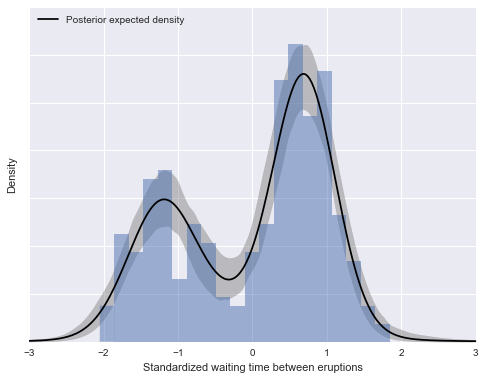

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20

ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, normed=True, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs.mean(axis=0),c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);


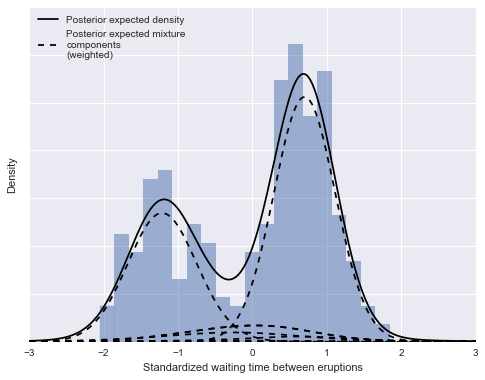

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, normed=True, lw=0, alpha=0.5);

ax.plot(x_plot, post_pdfs.mean(axis=0), c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],'--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),'--', c='k');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

### Example 2: Sunspot data

In [45]:
sunspot_df = get_rdataset('sunspot.year', cache=True).data

The model is specified as:
$$ 
\begin{align}
y_i|\lambda_i \sim Poisson(\lambda_i)\\
lambda_1,\lambda_2,\ldots \sim P\\
P\sim DP(\alpha, \Gamma(1,1))\\
\alpha\sim\Gamma(1,1)
\end{align}
$$

In [47]:
N = sunspot_df.shape[0]

K = 30
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta[:-1])]))
    component = pm.Categorical('component', w, shape=N)

    mu = pm.Uniform('mu', 0., 300., shape=K)
    obs = pm.Poisson('obs', mu[component], observed=sunspot_df['sunspot.year'])

Applied log-transform to alpha and added transformed alpha_log to model.
Applied logodds-transform to beta and added transformed beta_logodds to model.
Applied interval-transform to mu and added transformed mu_interval to model.


In [48]:
with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, mu, obs])
    step2 = pm.ElemwiseCategorical([component], np.arange(K))
    trace_ = pm.sample(2000, [step1, step2])

 [-----------------100%-----------------] 2000 of 2000 complete in 25.3 sec

In [50]:
trace = trace_[1000::10]

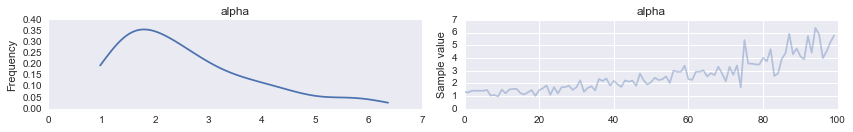

In [51]:
pm.traceplot(trace, varnames=['alpha']);

### Now we plot the results:


In [52]:
x_plot = np.arange(250)

In [53]:
post_pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(x_plot),
                                         trace['mu'][:, np.newaxis, :])
post_pmfs = (trace['w'][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1)

post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)

In [54]:
post_pmfs

array([[  1.53553839e-04,   1.05661474e-03,   3.63569811e-03, ...,
          7.91260573e-06,   7.78483689e-06,   7.64142269e-06],
       [  2.06610328e-04,   1.42165657e-03,   4.89140015e-03, ...,
          8.87915823e-06,   8.72514645e-06,   8.55514023e-06],
       [  2.06610328e-04,   1.42165657e-03,   4.89140015e-03, ...,
          8.87915823e-06,   8.72514645e-06,   8.55514023e-06],
       ..., 
       [  4.09841856e-04,   2.21160767e-03,   5.97044616e-03, ...,
          1.86997966e-05,   1.65334608e-05,   1.46063683e-05],
       [  3.70897207e-04,   2.07636006e-03,   5.81526025e-03, ...,
          1.74583450e-05,   1.56377112e-05,   1.40055994e-05],
       [  5.40122718e-04,   2.84226702e-03,   7.48231808e-03, ...,
          1.71770122e-05,   1.53374458e-05,   1.36762871e-05]])

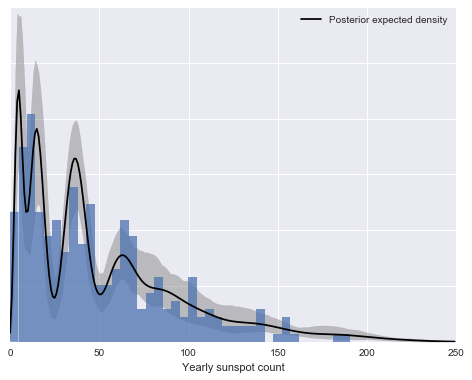

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['sunspot.year'].values, bins=40, normed=True, lw=0, alpha=0.75);

ax.fill_between(x_plot, post_pmf_low, post_pmf_high,
                 color='gray', alpha=0.45)
ax.plot(x_plot, post_pmfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);

## Non-parametric Random Effects in Hierarchical Models

A standard parametric assumption in linear and hierarchical modeling is that errors or random effects are Gaussian. For example,

$$y_i = X_i \beta + \epsilon_i$$

$$\epsilon_i \sim f$$

where the error distribution is typically specified as $f = N(0,\sigma^2)$. In robust regression, this restriction is partially relaxed by assuming a Student's $t$ model, which downweights the influence of outliers, but the shape is still restrictive.

A more flexible alternative is to use an infinite mixture of normals for $f$, using a Dirichlet process:

$$\begin{aligned}
P &\sim DP(\alpha P_0) \\
\tau_i &\sim P \\
\epsilon_i &\sim N(0, \tau_i^{-1})
\end{aligned}$$

If we specify $P_0$ as $\text{Gamma}(\nu/2, \nu/2)$, the corresponding DP is centered on a $t$ distribution, which still models the error distribution as unimodal and zero mean. 

In the context of hierarchical models, we may want to model individual variation in some parameter, such as a subject-varying mean:

$$\begin{aligned}y_{ij} &= \mu_i + \epsilon_{ij} \\
\mu_i &\sim f \\
\epsilon_{ij} &\sim g
\end{aligned}$$

where $y_{i}$ is a vector of $j = 1,\ldots,n_i$ repreated measurements for individual $i$. In the majority of applications, both $f$ and $g$ are specified with normal distributions.

If we want a less-restrictive form for this random effect, we can place a DP prior on the $\mu_{i}$.

$$\mu_i \sim P$$

$$P \sim DP(\alpha P_0)$$

This approach induces a latent class model on the $\mu_i$, where there are an unknown number of clusters:

$$\mu_i = \mu_{S_i}$$

$$Pr(S_i = h) = \pi_h$$

where $\pi_h$ is the probability of allocation to class $h = 1, \ldots, \infty$. This will result in a posterior distribution of cluster allocations (and hence, for the $\mu_i$), since the clustering is probabilistic.

Since we do not observe the $\mu_i$ directly, it relies on information in the repeated measurements for each individual, so this model will not be useful for $n_i$ = 1.

## References:

- Dunson D. Bayesian nonparametric hierarchical modeling. Biometrical Journal. January 2009.
- Teh, Y. W., & Jordan, M. I. (2010). Hierarchical Bayesian nonparametric models with applications. Bayesian nonparametrics, 158–207.

In [ ]:
Any Questions?